# Zero Curves and Spot Curves

Interest rate curves are commonly provided as either zero curves or spot curves.  They are different.

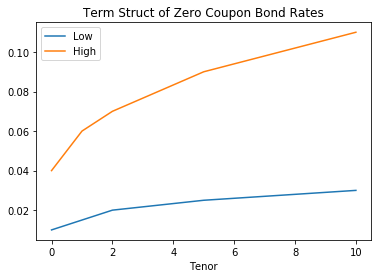

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
rates = pd.DataFrame({'Low':[0.01, 0.015, 0.02, 0.025, 0.03],
                     'High':[0.04, 0.06, 0.07, 0.09, 0.11],
                     'Tenor':[0,1,2,5,10]}).set_index(['Tenor'])
rp = rates.plot(title="Term Struct of Zero Coupon Bond Rates")

We often work with spot rates, such as the swap curve, but for proper treatment of value changes, we want a zero-coupon curve.  A spot curve has the property that the present value of a coupon bond with coupons equal to the quoted rate is 1.0.  We can use that fact to construct a spot curve out of the zero curve.

In [2]:
def spot_rate(zcb, tenor):
    times = np.arange(tenor, 0, step=-0.5)[::-1]
    if times.shape[0]==0:
        sr = None
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        coupons_pv_x = 0.5*np.exp(-r*times).sum()
        final_pv = np.exp(-tenor*r[-1])
        sr = (1.0 - final_pv) / coupons_pv_x # Solves x + c * delta = 1.0
    return sr
def compute_spot_rates(zcb_rates):
    spot = zcb_rates.copy()
    for curve in zcb_rates.columns:
        zcb = zcb_rates[curve]
        for tenor, rate in zcb.iteritems():
            if tenor>0.001:
                spot[curve][tenor] = spot_rate(zcb, tenor)
    return spot


Pricing a bond, with its coupons, on a zero curve is quite simple

In [3]:
def bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor, 0, step=-0.5)[::-1]
    if times.shape[0]==0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.5 * coupon_rate * np.exp(-r*times).sum()
    return p



Let's look at the zero curves we obtain from our spot rates in the swap curve above

            Low      High
Tenor                    
0      0.010000  0.040000
1      0.015047  0.060755
2      0.020037  0.070741
5      0.024962  0.089391
10     0.029666  0.104870
Bond price on this curve (should be 1.0)


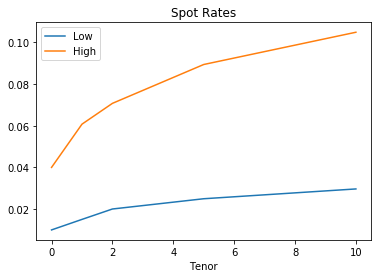

In [4]:
spot_rates = compute_spot_rates(rates)
print(spot_rates)
print("Bond price on this curve (should be 1.0)"%(
        bond_price(rates['High'], coupon_rate=spot_rates['High'][5], tenor=5)))

sp = spot_rates.plot(title="Spot Rates")

and now the differences

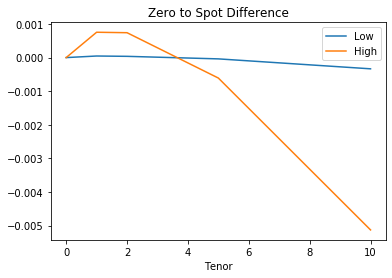

In [5]:
sp = (spot_rates-rates).plot(title="Zero to Spot Difference")

## ZCB Rates From Spot

To go from a spot curve to a ZCB curve, we have to compute the points one at a time.  The first one is the same as the zero rate.  Latter points are computed by bootstrapping, where we have zero rates for the previous tenor and just need to compute one new one at a time.  We proceed forward in tenors until the curve has been completely "stripped" in this manner.

In [7]:
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():
            if tenor>0.001:
                times = np.arange(tenor-0.5, 0, step=-0.5)[::-1]
                coupon_half_yr = 0.5*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_half_yr*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_half_yr))/tenor
    return zcb_rates
compute_zcb_curve(spot_rates)


,Low,High
Tenor,,
0,0.010000,0.040000
1,0.015000,0.059994
2,0.020000,0.069990
5,0.025001,0.090058
10,0.030019,0.111205
